### The flowchart for the deep learning model training and validation. 

In [2]:
import os
root_proj = '/Users/luo/OneDrive/GitHub/sentinel3-altimetry-l2'
os.chdir(root_proj)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from utils.dl_model import cnn_1d, nn_net
from utils.dl_train import train_model
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import torch.optim as optim


In [14]:
# root_dir = os.path.dirname(os.getcwd())
path_wf_dset = 'data/dset-waveform/dset_waveform.nc'
dir_model_save = 'model-cnn/'
dset_wf = xr.open_dataset(path_wf_dset)
dset_wf


<xarray.Dataset>
Dimensions:         (echo_sample_ind: 128, time_20_ku: 1221)
Coordinates:
  * time_20_ku      (time_20_ku) datetime64[ns] 2019-01-21T02:37:13.611894144...
    lat_20_ku       (time_20_ku) float64 ...
    lon_20_ku       (time_20_ku) float64 ...
Dimensions without coordinates: echo_sample_ind
Data variables:
    waveform_20_ku  (time_20_ku, echo_sample_ind) float64 ...
    waveform_cla    (time_20_ku) int64 ...

## Visualize the waveform and the corresponding label

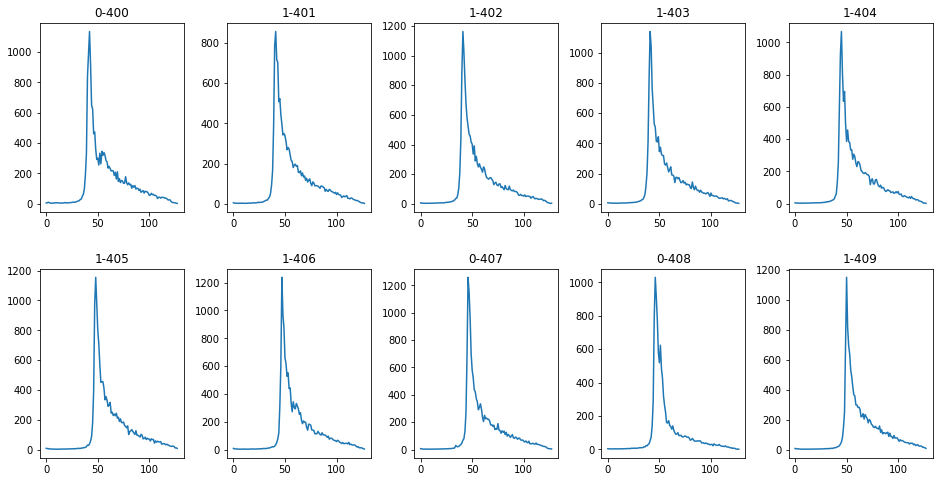

In [5]:
fig = plt.figure(figsize=(16,8))
for i,ind in enumerate(range(400,410)):
    ax = plt.subplot(2,5,i+1)
    ax.plot(dset_wf["waveform_20_ku"][ind])
    title = str(dset_wf['waveform_cla'][ind].values)+'-'+str(ind)
    plt.title(title)
plt.subplots_adjust(wspace=0.3, hspace=0.3)



## Configuration of the model training

In [7]:
model_cnn = cnn_1d()
model_nn = nn_net()
optimizer = optim.Adam(model_cnn.parameters(),lr=0.00005,betas=(0.9, 0.999),eps=1e-08)
loss_fun = nn.CrossEntropyLoss()
summary(model_cnn,(1,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 128]              64
       BatchNorm1d-2              [-1, 16, 128]              32
            Conv1d-3              [-1, 16, 128]             784
       BatchNorm1d-4              [-1, 16, 128]              32
            Conv1d-5               [-1, 32, 64]           1,568
       BatchNorm1d-6               [-1, 32, 64]              64
            Conv1d-7               [-1, 32, 64]           3,104
       BatchNorm1d-8               [-1, 32, 64]              64
            Conv1d-9               [-1, 64, 32]           6,208
      BatchNorm1d-10               [-1, 64, 32]             128
           Conv1d-11               [-1, 64, 32]          12,352
      BatchNorm1d-12               [-1, 64, 32]             128
           Conv1d-13              [-1, 128, 16]          24,704
      BatchNorm1d-14              [-1, 

## Data pipeline


In [15]:
## Training data 
wf = dset_wf['waveform_20_ku'].values
pos = np.linspace(0,1,128)
wf_nor = [wf[i]/np.max(wf[i]) for i in range(wf.shape[0])]
x_train = torch.Tensor(wf_nor[0:-400])
y_train = torch.Tensor(dset_wf['waveform_cla'].values[0:-400]).type(torch.LongTensor)
x_train = torch.unsqueeze(x_train, 1)
print(x_train.shape)
train_dset = TensorDataset(x_train, y_train)
train_dloader = DataLoader(train_dset, batch_size=8, shuffle=True,drop_last=True)
train_dloader
## Validation data
x_val = torch.Tensor(wf_nor[-400:])
y_val = torch.Tensor(dset_wf['waveform_cla'].values[-400:]).type(torch.LongTensor)
x_val = torch.unsqueeze(x_val, 1)
val_dset = TensorDataset(x_val, y_val)
val_dset = TensorDataset(x_val, y_val)
val_dloader = DataLoader(val_dset, batch_size=8, shuffle=False)
val_dloader

torch.Size([821, 1, 128])


## Model training

In [10]:
train_model(model=model_cnn, train_dloader=train_dloader, optimizer=optimizer, loss_fun=loss_fun, val_dloader=val_dloader, epochs=50, vis_step=5)


epoch: 1, loss_sum: 25.402042, acc_tra: 0.8811, acc_val: 0.8850
epoch: 6, loss_sum: 24.522977, acc_tra: 0.8946, acc_val: 0.8900
epoch: 11, loss_sum: 19.708167, acc_tra: 0.9167, acc_val: 0.8950
epoch: 16, loss_sum: 16.551916, acc_tra: 0.9387, acc_val: 0.8950
epoch: 21, loss_sum: 18.806081, acc_tra: 0.9326, acc_val: 0.8800
epoch: 26, loss_sum: 16.724201, acc_tra: 0.9289, acc_val: 0.8925
epoch: 31, loss_sum: 16.675121, acc_tra: 0.9375, acc_val: 0.8550
epoch: 36, loss_sum: 13.071412, acc_tra: 0.9522, acc_val: 0.8875
epoch: 41, loss_sum: 13.388441, acc_tra: 0.9510, acc_val: 0.8850
epoch: 46, loss_sum: 14.834198, acc_tra: 0.9387, acc_val: 0.8875


In [11]:
pred = model_cnn(x_val)
_, pred = torch.max(pred, 1)
## validation accuracy
count = (pred == y_val).sum().item()
acc = count/y_val.shape[0]
print('validation accuracy:', acc)


validation accuracy: 0.8725


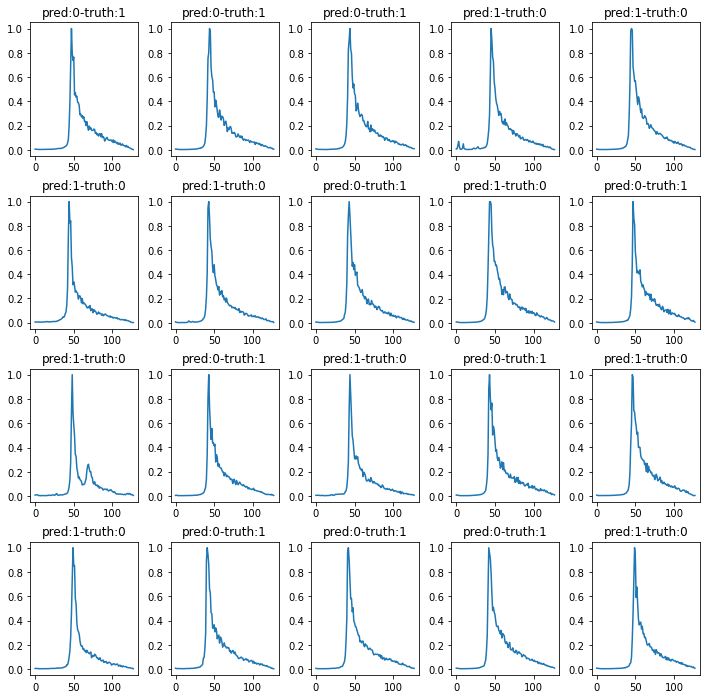

In [12]:
### !!!the wrong prediction checking
ind_error = np.where(pred != y_val)[0]
plt.figure(figsize=(12,12))
for i, ind in enumerate(ind_error[0:20]):
    ax = plt.subplot(4,5,i+1)
    plt.plot(x_val[ind][0])
    plt.title('pred:'+str(int(pred[ind]))+'-truth:'+str(int(y_val[ind])))
plt.subplots_adjust(wspace=0.3, hspace=0.3)


## Model save/loading

In [17]:
torch.save(model_cnn, dir_model_save+'cnn_1d_trained')
# model = torch.load(path_model)
# model.eval()